In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.colors as pc
from modified_spectral_method import *
from modified_louvain_method import *
from proxy_methods import *
import cvxpy as cp

In [2]:
normal_prices_data = pd.read_csv('data/reshaped_data.csv')
normal_prices_data = normal_prices_data.set_index('Date')
prices_data = np.log(normal_prices_data)
metadata = pd.read_csv('data/metadata.csv')
metadata = metadata.set_index('Ticker')
metadata['AverageRating'] = metadata['AverageRating'].astype(str)

In [68]:
# function to calculate proxy using the intersection method
def calculate_proxy_intersection_method(ticker, prices_data, communities, metadata):
    # identify the bucket to which the ticker belongs
    sector = metadata.loc[ticker]['Sector']
    region = metadata.loc[ticker]['Region']
    country = metadata.loc[ticker]['Country']
    # select a liquid bucket which is the average of government sector CDS
    liquid_bucket_tickers = metadata[(metadata['Sector'] == 'Government')].index.to_list()
    # calculate the average of the liquid bucket CDS
    liquid_bucket_prices = prices_data[liquid_bucket_tickers]
    a_0 = liquid_bucket_prices.mean(axis=1)
    # get the bucket to which the ticker belongs
    ticker_bucket = metadata[(metadata['Sector'] == sector) & (metadata['Region'] == region) & (metadata['Country'] == country)].index.to_list()
    # calculate the average of the ticker bucket CDS
    ticker_bucket_prices = prices_data[ticker_bucket]
    a_j = ticker_bucket_prices.mean(axis=1)
    # calculate the intersection proxy
    proxy = a_0 + a_j
    return proxy

def calculate_coefficients_csra_community_based(prices_data, communities, metadata, negative_coefficients=True):
    if not isinstance(communities[0], list):
        communities = [communities]
    coefficients = {}
    unique_sectors = metadata['Sector'].unique().tolist().remove('Government')
    unique_countries = metadata['Country'].unique()
    unique_ratings = metadata['AverageRating'].unique()

    for community_number, community in enumerate(communities):
        # Prepare the data for the community
        prices_data_community = prices_data[community]
        metadata_community = metadata.loc[community, :]

        sectors_community = metadata_community.loc[community, 'Sector'].unique().tolist()
        countries_community = metadata_community.loc[community, 'Country'].unique().tolist()
        ratings_community = metadata_community.loc[community, 'AverageRating'].unique().tolist()

        # Government data as intercept
        governments_data_community = prices_data[metadata[metadata['Sector'] == 'Government'].index.to_list()].mean(axis=1).to_numpy()
        governments_data_community = np.tile(governments_data_community, (prices_data_community.shape[1], 1))

        # Prepare the sectors data
        sectors_data_community = pd.DataFrame()
        for sector in sectors_community:
            sectors_data_community[sector] = prices_data_community[
                metadata_community[metadata_community['Sector'] == sector].index.to_list()
            ].mean(axis=1)
        sectors_data_community = sectors_data_community.T.to_numpy()

        # Prepare the countries data
        countries_data_community = pd.DataFrame()
        for country in countries_community:
            countries_data_community[country] = prices_data_community[
                metadata_community[metadata_community['Country'] == country].index.to_list()
            ].mean(axis=1)
        countries_data_community = countries_data_community.T.to_numpy()

        # Prepare the ratings data
        ratings_data_community = pd.DataFrame()
        for rating in ratings_community:
            ratings_data_community[rating] = prices_data_community[
                metadata_community[metadata_community['AverageRating'] == rating].index.to_list()
            ].mean(axis=1)
        ratings_data_community = ratings_data_community.T.to_numpy()

        prices_data_community = prices_data_community.T.to_numpy()

        # Create the masks
        mask_sectors = np.zeros((prices_data_community.shape[0], sectors_data_community.shape[0]))
        mask_countries = np.zeros((prices_data_community.shape[0], countries_data_community.shape[0]))
        mask_ratings = np.zeros((prices_data_community.shape[0], ratings_data_community.shape[0]))

        for i in range(prices_data_community.shape[0]):
            j = sectors_community.index(metadata_community.loc[community[i], 'Sector'])
            mask_sectors[i, j] = 1
        
        for i in range(prices_data_community.shape[0]):
            j = countries_community.index(metadata_community.loc[community[i], 'Country'])
            mask_countries[i, j] = 1

        for i in range(prices_data_community.shape[0]):
            j = ratings_community.index(metadata_community.loc[community[i], 'AverageRating'])
            mask_ratings[i, j] = 1

        # Define optimization variables
        row_vector_sectors = cp.Variable(sectors_data_community.shape[0])
        row_vector_countries = cp.Variable(countries_data_community.shape[0])
        row_vector_ratings = cp.Variable(ratings_data_community.shape[0])

        # Tiled matrices
        tiled_matrix_sectors = cp.vstack([row_vector_sectors] * prices_data_community.shape[0])
        tiled_matrix_countries = cp.vstack([row_vector_countries] * prices_data_community.shape[0])
        tiled_matrix_ratings = cp.vstack([row_vector_ratings] * prices_data_community.shape[0])

        # Apply masks
        masked_matrix_sectors = cp.multiply(tiled_matrix_sectors, mask_sectors)
        masked_matrix_countries = cp.multiply(tiled_matrix_countries, mask_countries)
        masked_matrix_ratings = cp.multiply(tiled_matrix_ratings, mask_ratings)

        print('MASKED_MATRIX', masked_matrix_sectors.shape)
        print('SECTORS_DATA', sectors_data_community.shape)
        # Contributions
        contribution_sectors = masked_matrix_sectors @ sectors_data_community
        contribution_countries = masked_matrix_countries @ countries_data_community
        contribution_ratings = masked_matrix_ratings @ ratings_data_community

        # Define the objective function
        objective = cp.Minimize(
            cp.norm(
                prices_data_community
                - contribution_sectors
                - contribution_countries
                - contribution_ratings
                - governments_data_community,
                "fro",
            )**2
        )

        # Constraints
        constraints = [
            row_vector_sectors >= 0,
            row_vector_countries >= 0,
            row_vector_ratings >= 0
        ]

        # Solve the optimization problem
        if negative_coefficients:
            problem = cp.Problem(objective)
        else:
            problem = cp.Problem(objective, constraints)
        problem.solve()

        # Store the coefficients
        sectors_df = pd.DataFrame({'Name': sectors_community, 'Coefficient': row_vector_sectors.value, 'Type': 'Sector'})
        countries_df = pd.DataFrame({'Name': countries_community, 'Coefficient': row_vector_countries.value, 'Type': 'Country'})
        ratings_df = pd.DataFrame({'Name': ratings_community, 'Coefficient': row_vector_ratings.value, 'Type': 'Rating'})
        
        # Combine all DataFrames
        coefficients_df = pd.concat([sectors_df, countries_df, ratings_df], ignore_index=True)
        coefficients_df = coefficients_df.set_index('Name')
        coefficients[f'community_{community_number+1}'] = coefficients_df

    return coefficients


In [70]:
correlation_matrix, T, N, tickers = create_correlation_matrix('data/eur_data_standardized_returns.csv')  
C_g = calculate_C_g(correlation_matrix, T, N)
result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, tickers, min_size=2, modularity_threshold=0.00001)
print(f"number of communities detected:{len(company_communities)}")
ticker_proxy = company_communities[len(company_communities)-1][6]
print(f"Calculating proxy for ticker {ticker_proxy}")
print(f'The ticker {ticker_proxy} belongs to the community {len(company_communities)} and sector {metadata.loc[ticker_proxy]["Sector"]} and country {metadata.loc[ticker_proxy]["Region"]}')

# calculate the proxy using the intersection method
proxy = calculate_proxy_intersection_method(ticker_proxy, prices_data, company_communities, metadata)
correlation = np.corrcoef(prices_data[ticker_proxy], proxy)[0, 1]
print(f"Correlation between the proxy and the ticker {ticker_proxy} is {correlation}")
# calculate the RMSE between the proxy and the ticker
rmse = np.sqrt(np.mean((prices_data[ticker_proxy] - proxy)**2))
print(f"RMSE between the proxy and the ticker {ticker_proxy} is {rmse}")

# calculate the coefficients using the CSRA method
coefficients = calculate_coefficients_csra_community_based(prices_data, company_communities, metadata, negative_coefficients=True)
for key, value in coefficients.items():
    print(key)
    print(value)
    print("")

number of communities detected:3
Calculating proxy for ticker AF-AirFrance
The ticker AF-AirFrance belongs to the community 3 and sector Consumer Services and country Europe
Correlation between the proxy and the ticker AF-AirFrance is 0.9112644864850366
RMSE between the proxy and the ticker AF-AirFrance is 3.5805881981954775
MASKED_MATRIX (41, 7)
SECTORS_DATA (7, 2515)
MASKED_MATRIX (85, 10)
SECTORS_DATA (10, 2515)
MASKED_MATRIX (192, 11)
SECTORS_DATA (11, 2515)
community_1
                    Coefficient     Type
Name                                    
Financials             0.371658   Sector
Government             0.216463   Sector
Utilities              0.240052   Sector
Consumer Services      0.106280   Sector
Basic Materials        0.170707   Sector
Telecommunications     0.108307   Sector
Industrials            0.317994   Sector
France                 0.075494  Country
Netherlands            0.148557  Country
Greece                 0.458071  Country
Germany                0.0351

In [62]:
def calculate_b0(prices_data, metadata, bucket):
    """
    Calculate b_0 for a given bucket, applying log transformation to prices first.
    
    Parameters:
        prices_data (pd.DataFrame): DataFrame where columns are tickers and rows are price data over time (dates as index).
        metadata (pd.DataFrame): DataFrame where rows are tickers and columns describe metadata (e.g., Sector, Country, Rating).
        bucket (list): A list specifying the bucket [Sector, Country, AverageRating].
        
    Returns:
        float: The calculated b_0 value (mean of the log-transformed prices of the bucket).
    """
    # Unpack bucket values
    sector, country, rating = bucket
    
    # Find tickers in the given bucket
    tickers_in_bucket = metadata[
        (metadata['Sector'] == sector) &
        (metadata['Country'] == country) &
        (metadata['AverageRating'] == rating)
    ].index
    
    # Pull price data for the valid tickers
    bucket_prices = prices_data[tickers_in_bucket]
    
    # Calculate the mean of the log-transformed prices
    mean_log_price = bucket_prices.mean(axis = 1)
    
    return mean_log_price


def count_cds_buckets(metadata):
    """
    Count the number of CDS in each bucket based on metadata and include the tickers in each bucket.
    
    Parameters:
        metadata (pd.DataFrame): DataFrame containing metadata with columns like 'Sector', 'Country', and 'AverageRating'.
        
    Returns:
        pd.DataFrame: A DataFrame with the count of CDS and the tickers in each bucket.
    """
    # Group by the bucket columns (Sector, Country, AverageRating) and aggregate the tickers
    bucket_counts = metadata.groupby(['Sector', 'Country', 'AverageRating']).agg(
        CDS_Count=('Sector', 'size'),  # Count the number of entries in the bucket
        Tickers=('Sector', lambda x: list(x.index))  # Collect tickers (index values)
    )
    
    # Reset the index for readability
    bucket_counts_df = bucket_counts.reset_index()
    
    return bucket_counts_df

def get_bucket_for_cds(metadata, ticker):
    """
    Look up the bucket (Sector, Country, AverageRating) for a given CDS ticker in metadata.
    
    Parameters:
        metadata (pd.DataFrame): DataFrame containing metadata with columns like 'Sector', 'Country', 'AverageRating'.
        ticker (str): The ticker for which to look up the bucket.
        
    Returns:
        list: A list representing the bucket [Sector, Country, AverageRating] for the given ticker.
    """
    if ticker not in metadata.index:
        raise ValueError(f"Ticker '{ticker}' not found in metadata.")
    
    # Extract the bucket information
    sector = metadata.at[ticker, 'Sector']
    country = metadata.at[ticker, 'Country']
    average_rating = metadata.at[ticker, 'AverageRating']
    
    return [sector, country, average_rating]

In [110]:
bucket = get_cds_bucket(metadata, 'AEGON')
print(bucket)

['Financials', 'Netherlands', '10']


In [66]:
calculate_b0(prices_data, metadata, bucket)

Date
2010-09-14 00:00:00    5.064216
2010-09-15 00:00:00    5.071165
2010-09-16 00:00:00    5.056579
2010-09-17 00:00:00    5.053244
2010-09-20 00:00:00    5.062543
                         ...   
2020-04-28 00:00:00    4.796077
2020-04-29 00:00:00    4.795933
2020-04-30 00:00:00    4.787211
2020-05-01 00:00:00    4.795345
2020-05-04 00:00:00    4.812347
Length: 2515, dtype: float64

In [106]:
count_df = count_cds_buckets(metadata)

# Filter buckets with CDS_Count >= X so buckets have X or more CDS in it
x = 1
filtered_buckets = count_df[count_df['CDS_Count'] >= 3]
filtered_buckets

,Sector,Country,AverageRating,CDS_Count,Tickers
14,Basic Materials,Switzerland,10,3,"[BSFSHW, CLAR, GLCORE]"
21,Consumer Goods,France,10,3,"[DANONE, RENAUL-RCIBanq, VLOF]"
27,Consumer Goods,Germany,10,4,"[CONTI, DAMLR, RBOSCH, RHEINM-Rheinmet]"
35,Consumer Goods,Sweden,17,3,"[ELTLX, SCACAP, SWEMAT]"
37,Consumer Goods,United Kingdom,10,5,"[ALYD, BATSLN, HEIANA-SCOT, JAPTOB-GGL, TWPLC]"
41,Consumer Services,France,10,4,"[ACCOR, DEXO, HAVAS, LAGARD]"
52,Consumer Services,United Kingdom,10,12,"[ABHLTD, AYLL, CCLL, DFHH, FGPLN, IHOT, ITV-Ca..."
53,Consumer Services,United Kingdom,17,10,"[DMGOLN, EMIG, EXPGRL-EXPFIN, ITV, MKS, MKS-M+..."
63,Financials,France,10,6,"[ACAFP-CIB, AXAF, DEXGRP-CredLoc, GFCFP, PEUGO..."
64,Financials,France,5,3,"[ACAFP, BNP, SCORS]"


In [100]:
def csra_b0_intercept(prices_data, communities, metadata, bucket, negative_coefficients=True):
    """
    Calculates coefficients for the CSRA method with b_0 as the intercept.
    
    Parameters:
        prices_data (pd.DataFrame): DataFrame with price data, columns are tickers, and rows are dates.
        communities (list): List of lists, where each sublist is a community of tickers.
        metadata (pd.DataFrame): Metadata describing tickers with columns like 'Sector', 'Country', 'AverageRating'.
        bucket (list): The reference bucket [Sector, Country, AverageRating] to calculate b_0.
        negative_coefficients (bool): If False, coefficients are constrained to be non-negative.
        
    Returns:
        dict: A dictionary of coefficients for each community.
    """
    if not isinstance(communities[0], list):
        communities = [communities]
    coefficients = {}
    
    # Calculate b_0 for the given bucket
    b0_value = calculate_b0(prices_data, metadata, bucket)


    for community_number, community in enumerate(communities):
        # Prepare the data for the community
        prices_data_community = prices_data[community]
        metadata_community = metadata.loc[community, :]

        b0_value = np.tile(b0_value, (prices_data_community.shape[1], 1))
        print(b0_value.shape)

        sectors_community = metadata_community['Sector'].unique().tolist()
        countries_community = metadata_community['Country'].unique().tolist()
        ratings_community = metadata_community['AverageRating'].unique().tolist()

        # Exclude the reference factors
        sectors_community = [sector for sector in sectors_community if sector != bucket[0]]
        countries_community = [country for country in countries_community if country != bucket[1]]
        ratings_community = [rating for rating in ratings_community if rating != bucket[2]]

        # Prepare the sectors data
        sectors_data_community = pd.DataFrame()
        for sector in sectors_community:
            sectors_data_community[sector] = prices_data_community[
                metadata_community[metadata_community['Sector'] == sector].index.to_list()
            ].mean(axis=1)
        sectors_data_community = sectors_data_community.T.to_numpy()

        # Prepare the countries data
        countries_data_community = pd.DataFrame()
        for country in countries_community:
            countries_data_community[country] = prices_data_community[
                metadata_community[metadata_community['Country'] == country].index.to_list()
            ].mean(axis=1)
        countries_data_community = countries_data_community.T.to_numpy()

        # Prepare the ratings data
        ratings_data_community = pd.DataFrame()
        for rating in ratings_community:
            ratings_data_community[rating] = prices_data_community[
                metadata_community[metadata_community['AverageRating'] == rating].index.to_list()
            ].mean(axis=1)
        ratings_data_community = ratings_data_community.T.to_numpy()

        prices_data_community = prices_data_community.T.to_numpy()

        # Create the masks
        mask_sectors = np.zeros((prices_data_community.shape[0], sectors_data_community.shape[0]))
        mask_countries = np.zeros((prices_data_community.shape[0], countries_data_community.shape[0]))
        mask_ratings = np.zeros((prices_data_community.shape[0], ratings_data_community.shape[0]))
        
        for i in range(prices_data_community.shape[0]):
            sector = metadata_community.loc[community[i], 'Sector']
            if sector in sectors_community:  # Only process if the sector is not excluded
                j = sectors_community.index(sector)
                mask_sectors[i, j] = 1
        
        for i in range(prices_data_community.shape[0]):
            country = metadata_community.loc[community[i], 'Country']
            if country in countries_community:  # Only process if the country is not excluded
                j = countries_community.index(country)
                mask_countries[i, j] = 1
        
        for i in range(prices_data_community.shape[0]):
            rating = metadata_community.loc[community[i], 'AverageRating']
            if rating in ratings_community:  # Only process if the rating is not excluded
                j = ratings_community.index(rating)
                mask_ratings[i, j] = 1

        # Define optimization variables
        row_vector_sectors = cp.Variable(sectors_data_community.shape[0])
        row_vector_countries = cp.Variable(countries_data_community.shape[0])
        row_vector_ratings = cp.Variable(ratings_data_community.shape[0])

        # Tiled matrices
        tiled_matrix_sectors = cp.vstack([row_vector_sectors] * prices_data_community.shape[0])
        tiled_matrix_countries = cp.vstack([row_vector_countries] * prices_data_community.shape[0])
        tiled_matrix_ratings = cp.vstack([row_vector_ratings] * prices_data_community.shape[0])

        # Apply masks
        masked_matrix_sectors = cp.multiply(tiled_matrix_sectors, mask_sectors)
        masked_matrix_countries = cp.multiply(tiled_matrix_countries, mask_countries)
        masked_matrix_ratings = cp.multiply(tiled_matrix_ratings, mask_ratings)

        # Contributions
        contribution_sectors = masked_matrix_sectors @ sectors_data_community
        contribution_countries = masked_matrix_countries @ countries_data_community
        contribution_ratings = masked_matrix_ratings @ ratings_data_community

        # Define the objective function using b_0
        objective = cp.Minimize(
            cp.norm(
                prices_data_community
                - b0_value
                - contribution_sectors
                - contribution_countries
                - contribution_ratings,
                "fro",
            )**2
        )

        # Constraints
        constraints = []
        if not negative_coefficients:
            constraints = [
                row_vector_sectors >= 0,
                row_vector_countries >= 0,
                row_vector_ratings >= 0
            ]

        # Solve the optimization problem
        problem = cp.Problem(objective, constraints)
        problem.solve()

        # Store the coefficients
        sectors_df = pd.DataFrame({'Name': sectors_community, 'Coefficient': row_vector_sectors.value, 'Type': 'Sector'})
        countries_df = pd.DataFrame({'Name': countries_community, 'Coefficient': row_vector_countries.value, 'Type': 'Country'})
        ratings_df = pd.DataFrame({'Name': ratings_community, 'Coefficient': row_vector_ratings.value, 'Type': 'Rating'})
        
        # Combine all DataFrames
        coefficients_df = pd.concat([sectors_df, countries_df, ratings_df], ignore_index=True)
        coefficients_df = coefficients_df.set_index('Name')
        coefficients[f'community_{community_number+1}'] = coefficients_df

    return coefficients


In [74]:
def construct_proxy_single_cds(cds_entity, prices_data, metadata, coefficients, communities):
    """
    Constructs a proxy value for a single CDS entity.

    Parameters:
        cds_entity (str): The ID of the CDS entity to proxy.
        prices_data (pd.DataFrame): The prices data.
        metadata (pd.DataFrame): The metadata for sectors, countries, and average ratings.
        coefficients (dict): The coefficients calculated for communities.
        communities (list of list): List of communities, each containing a list of CDS entities.

    Returns:
        float: The proxy value for the given CDS.
    """
    # Find the community index for the CDS entity
    community_index = None
    for i, community in enumerate(communities):
        if cds_entity in community:
            community_index = i + 1
            break
    if community_index is None:
        raise ValueError(f"CDS entity {cds_entity} not found in any community.")

    print(f"{cds_entity} belongs to community {community_index}")
    
    # Metadata for the CDS entity
    sector = metadata.loc[cds_entity, 'Sector']
    country = metadata.loc[cds_entity, 'Country']
    average_rating = metadata.loc[cds_entity, 'AverageRating']
    
    # Retrieve coefficients for the given community
    community_coefficients = coefficients[f'community_{community_index}']
    
    # Retrieve sector, country, and rating contributions
    sector_contribution = community_coefficients.loc[sector, 'Coefficient'] if sector in community_coefficients.index else 0
    country_contribution = community_coefficients.loc[country, 'Coefficient'] if country in community_coefficients.index else 0
    rating_contribution = community_coefficients.loc[average_rating, 'Coefficient'] if average_rating in community_coefficients.index else 0
    
    # Government intercept (log space)
    governments_data = prices_data[metadata[metadata['Sector'] == 'Government'].index.to_list()].mean(axis=1).to_numpy()
    governments_data_log = np.log(governments_data.mean())  # Average over time
    
    # Compute log proxy
    log_proxy = sector_contribution + country_contribution + rating_contribution + governments_data_log
    
    # Convert back from log space
    proxy = np.exp(log_proxy)
    
    return proxy, community_index


In [102]:
# All companies
combined_communities = [[item for sublist in company_communities for item in sublist]]

# The coefficients using the CSRA method over the whole dataset
coefficients_b0 = csra_b0_intercept(prices_data, combined_communities, metadata, bucket, negative_coefficients=True)

(318, 2515)


In [112]:
# Define the CDS entity to proxy
cds_entity = "AEGON"

# Construct the proxy for the single CDS
proxy_value, community_index = construct_proxy_single_cds(cds_entity, prices_data, metadata, coefficients, combined_communities)
print(f"Proxy value for {cds_entity}: {proxy_value}")

AEGON belongs to community 1
Proxy value for AEGON: 4.626601387991932


In [114]:
def construct_proxy_cds_timeseries(cds_entity, prices_data, metadata, coefficients, community_index):
    """
    Constructs a time series of proxy values for a single CDS entity.

    Parameters:
        cds_entity (str): The ID of the CDS entity to proxy.
        prices_data (pd.DataFrame): The prices data (time series).
        metadata (pd.DataFrame): Metadata for sectors, countries, and ratings.
        coefficients (dict): Coefficients calculated for communities.
        community_index (int): The index of the community the CDS belongs to.

    Returns:
        pd.Series: Time series of proxy values for the CDS entity.
    """
    # Metadata for the CDS entity
    sector = metadata.loc[cds_entity, 'Sector']
    country = metadata.loc[cds_entity, 'Country']
    rating = metadata.loc[cds_entity, 'AverageRating']
    
    # Retrieve coefficients for the given community
    community_coefficients = coefficients[f'community_{community_index}']
    
    # Retrieve sector, country, and rating contributions
    sector_contribution = community_coefficients.loc[sector, 'Coefficient'] if sector in community_coefficients.index else 0
    country_contribution = community_coefficients.loc[country, 'Coefficient'] if country in community_coefficients.index else 0
    rating_contribution = community_coefficients.loc[rating, 'Coefficient'] if rating in community_coefficients.index else 0
    
    # Government intercept (time series, log space)
    governments_data = prices_data[metadata[metadata['Sector'] == 'Government'].index.to_list()].mean(axis=1)
    governments_data_log = np.log(governments_data)
    
    # Compute log proxy time series
    log_proxy_series = (
        governments_data_log
        + sector_contribution
        + country_contribution
        + rating_contribution
    )
    
    # Convert back from log space to original scale
    proxy_series = np.exp(log_proxy_series)
    
    # Return as pandas Series with the same index as the time series
    return pd.Series(proxy_series, index=prices_data.index)

def plot_timeseries_comparison(proxy_timeseries, prices_data, cds_entity):
    """
    Plots the time series proxy alongside the original time series for a single CDS entity.

    Parameters:
        proxy_timeseries (np.ndarray): Time series of proxy values for the CDS.
        prices_data (pd.DataFrame): The prices data (used to extract original time series and time steps).
        cds_entity (str): The ID of the CDS entity being plotted.
    """
    # Ensure the index is in datetime format
    if not isinstance(prices_data.index, pd.DatetimeIndex):
        prices_data.index = pd.to_datetime(prices_data.index)
    
    # Extract the time steps and original time series
    time_steps = prices_data.index
    original_timeseries = prices_data[cds_entity]
    
    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, proxy_timeseries, label=f"Proxy for {cds_entity}", linewidth=2, color='blue')
    plt.plot(time_steps, original_timeseries, label=f"Original {cds_entity}", linewidth=2, color='red')
    
    # Format the x-axis (dates)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show one tick per year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as "Year"
    plt.xticks(rotation=45)  # Rotate x-axis labels to prevent overlap
    
    # Labels and title
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Comparison of Proxy and Original Time Series for {cds_entity}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

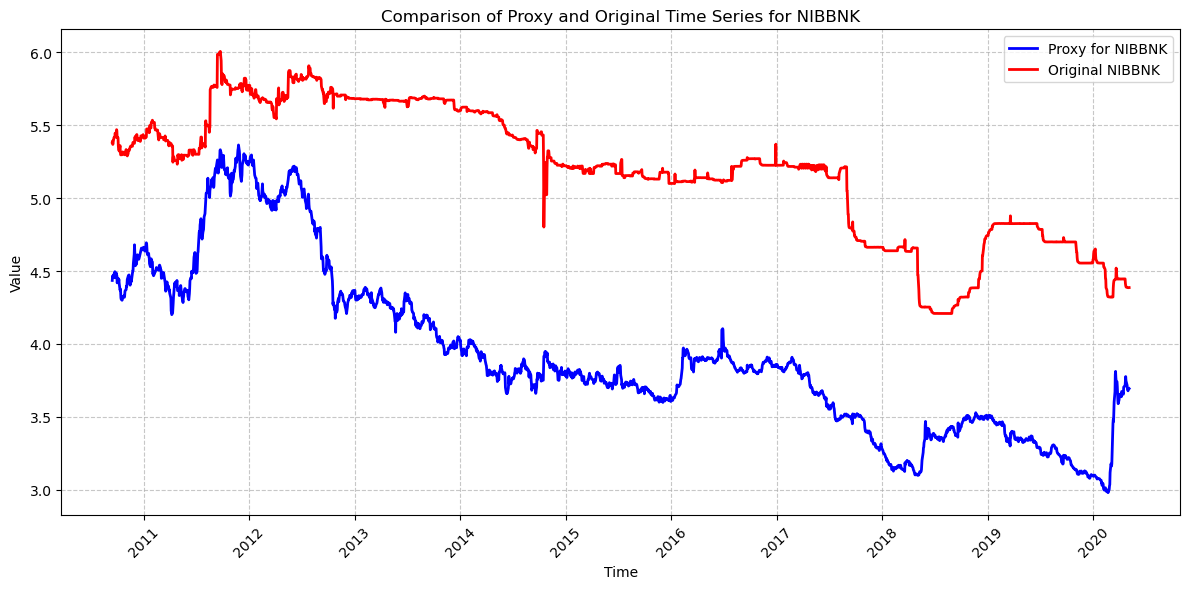

In [120]:
cds_entity = "NIBBNK"

# Construct the time series proxy for the single CDS
proxy_timeseries = construct_proxy_cds_timeseries(cds_entity, prices_data, metadata, coefficients_b0, community_index)

plot_timeseries_comparison(proxy_timeseries, prices_data, cds_entity)

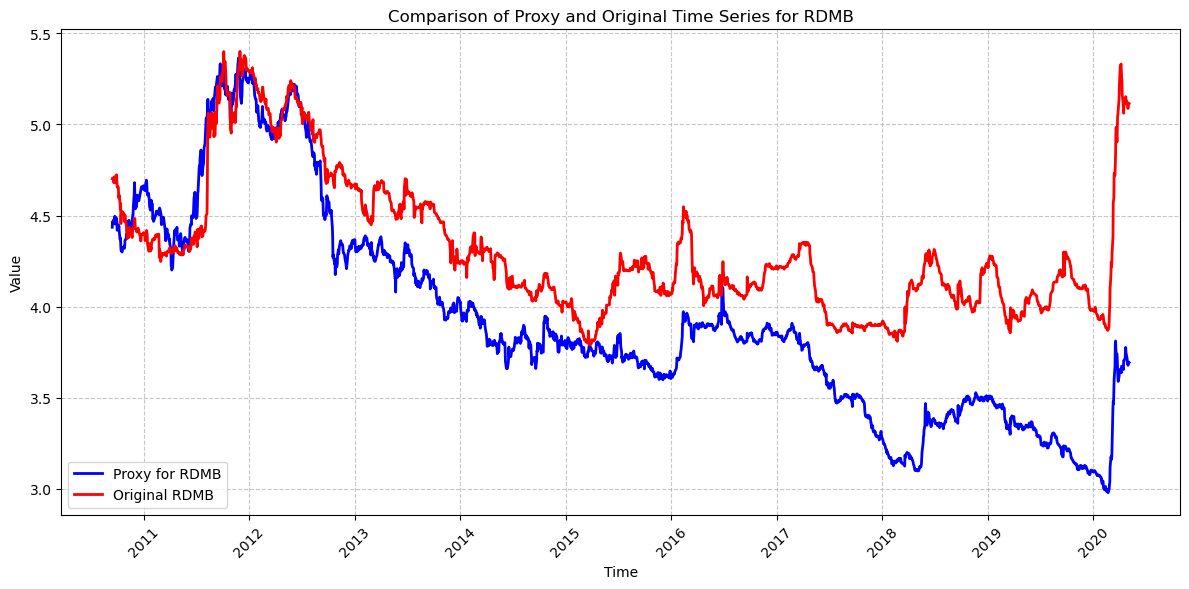

In [118]:
# Define the CDS entity to proxy
cds_entity = "RDMB"

# Construct the time series proxy for the single CDS
proxy_timeseries = construct_proxy_cds_timeseries(cds_entity, prices_data, metadata, coefficients_b0, community_index)

plot_timeseries_comparison(proxy_timeseries, prices_data, cds_entity)